In [8]:
import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import cluster
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn import pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import model_selection   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from sklearn.cluster import MiniBatchKMeans
import os
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
IN_COLLAB = True

N_COLLAB = True
SUBMIT = True

if IN_COLLAB:
    files_directory = '/content/drive/My Drive/'
else:
    files_directory = ''


def pre_process(df):    
    StartTime = pd.to_datetime(df['Timestamp'], infer_datetime_format=True)
    
    df['Day_in_week'] = StartTime.dt.dayofweek
    # df['Day_in_year'] = StartTime.dt.dayofyear
    # df['Month'] = StartTime.dt.month
    df['Hour_in_Day'] = StartTime.dt.hour
    df = df.drop('Timestamp', axis=1)
    
    return df


def add_weather(trips_df, weather_df):
    trips_df['Timestamp'] = pd.to_datetime(trips_df['Timestamp'], infer_datetime_format=True)
    weather_df['date'] = pd.to_datetime(weather_df['date'], infer_datetime_format=True)
    
    trips_df['date'] = trips_df['Timestamp'].dt.date
    weather_df['date'] = weather_df['date'].dt.date
    
    df = pd.merge(trips_df, weather_df, how='left', on='date').drop('date', axis=1)
    return df


def clean_training_set(trips_df):
    return trips_df[(trips_df['Trip_distance'] / 1000) / (trips_df['ETA'] / (60 * 60)) <= 200]


def split_X_y(df):
    return df.drop(['ETA', 'ID'], axis=1), df['ETA']


train = pd.read_csv(os.path.join(files_directory, 'Train.csv'))
submission_test_set = pd.read_csv(os.path.join(files_directory, 'Test.csv'))
weather = pd.read_csv(os.path.join(files_directory, 'Weather.csv'))

train = train.sort_values('Timestamp', ascending=False)
train = clean_training_set(train)

train = pre_process(train)
submission_test_set = pre_process(submission_test_set)

full_train = train.copy()

print('splitting into test, validation and training sets')
test = train.iloc[:8000]
train = train.iloc[8000:]

val = train.iloc[:8000]
train = train.iloc[8000:]

X_train, y_train = split_X_y(train)
X_val, y_val = split_X_y(val)
X_test, y_test = split_X_y(test)


target='ETA'
idCol='ID'


splitting into test, validation and training sets


In [98]:
X_train.head(5)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,pickup_cluster,dropoff_cluster,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,Day_in_week,Month
60437,3.045,36.805,3.052,36.794,1780,92,165,-0.014388,-0.065599,-0.006623,-0.055125,4,12
67917,3.218,36.715,3.219,36.716,135,193,193,0.164575,0.011870,0.165501,0.010801,4,12
29720,2.972,36.789,3.031,36.769,8936,176,196,-0.086065,-0.044448,-0.025792,-0.028695,4,12
2615,2.953,36.763,2.932,36.749,6014,181,42,-0.103168,-0.017163,-0.123119,-0.001705,4,12
45979,3.207,36.698,3.108,36.743,12678,54,59,0.154812,0.029609,0.052862,-0.008236,4,12


In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# xgb1 = XGBRegressor(
#  learning_rate =0.01,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  nthread=4,
#  scale_pos_weight=1,
#  seed=20)

In [99]:
xgb1.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1188.51	validation_1-rmse:1180.48
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1134.38	validation_1-rmse:1126.2
[2]	validation_0-rmse:1083.67	validation_1-rmse:1074.81
[3]	validation_0-rmse:1031.66	validation_1-rmse:1022.64
[4]	validation_0-rmse:982.311	validation_1-rmse:973.207
[5]	validation_0-rmse:935.504	validation_1-rmse:926.317
[6]	validation_0-rmse:891.101	validation_1-rmse:881.746
[7]	validation_0-rmse:848.996	validation_1-rmse:839.575
[8]	validation_0-rmse:809.106	validation_1-rmse:799.681
[9]	validation_0-rmse:771.33	validation_1-rmse:761.848
[10]	validation_0-rmse:735.481	validation_1-rmse:726.018
[11]	validation_0-rmse:701.523	validation_1-rmse:692.119
[12]	validation_0-rmse:669.342	validation_1-rmse:660.024
[13]	validation_0-rmse:638.865	validation_1-rmse:629.572
[14]	validation_0-rmse:610.062	validation_1-rmse:600.86

KeyboardInterrupt: ignored

In [116]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': range(3,10,2),
              'min_child_weight': range(1,6,2),
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: ignored

In [14]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 objective='reg:squarederror',
 tree_method='gpu_hist'if IN_COLLAB else 'hist',
 n_estimators=7000,
 max_depth=20,
 max_leaves=120,
 min_child_weight=2,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.8,
 scale_pos_weight=1)
xgb1.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=200, 
    early_stopping_rounds = 15)

[0]	validation_0-rmse:1128.24	validation_1-rmse:1119.95
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[200]	validation_0-rmse:119.964	validation_1-rmse:159.88
[400]	validation_0-rmse:99.3246	validation_1-rmse:154.675
Stopping. Best iteration:
[503]	validation_0-rmse:92.311	validation_1-rmse:153.458



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, max_leaves=120, min_child_weight=2, missing=None,
             n_estimators=7000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7, tree_method='gpu_hist', verbosity=1)

In [5]:
pd.DataFrame({'Variable':X_train.columns,
              'Importance':xgb1.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
4,Trip_distance,0.745416
3,Destination_lon,0.075316
1,Origin_lon,0.057959
2,Destination_lat,0.050040
0,Origin_lat,0.036675
6,Hour_in_Day,0.023701
5,Day_in_week,0.010894


In [6]:
model = xgb.XGBRegressor(
    n_estimators=5000,
    objective='reg:squarederror',
    tree_method='gpu_hist'if IN_COLLAB else 'hist',
    gpu_id=0
)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=200
)

[0]	validation_0-rmse:1105.92
[200]	validation_0-rmse:186.323
[400]	validation_0-rmse:179.214
[600]	validation_0-rmse:176.016
[800]	validation_0-rmse:173.36
[1000]	validation_0-rmse:171.253
[1200]	validation_0-rmse:169.848
[1400]	validation_0-rmse:169.186


KeyboardInterrupt: ignored

In [9]:
submission = pd.DataFrame({'ID': submission_test_set['ID'], 'ETA': xgb1.predict(submission_test_set.drop('ID', axis=1))})
submission.to_csv('submission.csv', index=False)

In [120]:
xgb1 = XGBRegressor(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=5,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1)
xgb1.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 15)

[15:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1188.52	validation_1-rmse:1180.57
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:1131.1	validation_1-rmse:1122.95
[2]	validation_0-rmse:1076.62	validation_1-rmse:1068.35
[3]	validation_0-rmse:1024.92	validation_1-rmse:1016.56
[4]	validation_0-rmse:975.897	validation_1-rmse:967.522
[5]	validation_0-rmse:929.408	validation_1-rmse:921.066
[6]	validation_0-rmse:885.316	validation_1-rmse:876.995
[7]	validation_0-rmse:843.54	validation_1-rmse:835.146
[8]	validation_0-rmse:805.877	validation_1-rmse:797.421
[9]	validation_0-rmse:770.398	validation_1-rmse:761.883
[10]	validation_0-rmse:734.595	validation_1-rmse:726.155
[11]	validation_0-rmse:702.405	validation_1-rmse:693.966
[12]	validation_0-rmse:670.157	validation_

KeyboardInterrupt: ignored

In [47]:
train2=pd.DataFrame(train2)
train2.insert(0, 'ID', train['ID'])
train2.insert(len(train2.columns),'ETA', train['ETA'])

test2 =pd.DataFrame(test2) 
test2.insert(0, 'ID', train['ID'])
test2.insert(len(test2.columns),'ETA', train['ETA'])

In [51]:
#train2.head(20)
test2.head(20)

,ID,0,1,2,3,4,5,6,7,8,9,10,11,12,ETA
0,000FLWA8,-2.605338,1.415119,0.033086,0.791725,-2.583667,-0.292416,-1.356334,0.139301,0.133514,0.082578,-1.087305,1.621610,2.442835,2784.0
1,000RGOAM,-2.626237,-1.333876,-1.089742,0.992103,0.026560,0.349635,-0.724088,-0.261990,-1.077926,-0.966660,-1.252033,0.202001,2.330357,576.0
2,001QSGIH,-2.619340,0.120213,-0.049899,0.840704,-1.146870,0.125894,-0.234500,-0.438223,-0.650830,-0.447779,-1.971766,0.457904,2.383583,526.0
3,002ACV6R,-2.620778,-1.358906,-0.843159,0.957583,0.072736,0.358791,-1.443568,0.105316,0.012819,-0.027121,-1.665094,0.623448,2.392878,3130.0
4,NaN,-2.621126,-1.374821,-0.868885,0.961301,0.046760,0.353642,-1.429790,0.099562,0.015639,-0.024458,-1.663274,0.628168,2.393174,NaN
5,003B9LE9,-2.608874,-1.785298,1.922861,0.623325,1.579027,0.695593,-2.619727,0.789187,1.543286,1.039100,0.297531,-0.099967,2.410658,1341.0
6,004K2C9W,-2.644623,-1.222183,0.747058,0.776627,-1.284989,0.208003,1.280402,-0.940495,-0.108727,-0.135777,0.520357,-0.185047,2.371292,606.0
7,004LD40Z,-2.633728,-2.284485,-0.477060,0.946314,-0.075827,0.370544,-1.039577,-0.008619,0.781181,0.516912,-0.351577,-0.627951,2.379716,451.0
8,005H5Q6S,-2.633728,-2.284541,-0.477105,0.946327,-0.075858,0.370530,-1.039606,-0.008635,0.781009,0.516769,-0.351687,-0.628289,2.379699,587.0
9,006DWCWR,-2.638569,0.460466,2.789471,0.429773,0.325187,0.770925,3.001941,-1.521830,0.610218,0.893136,-1.455823,2.758934,2.538996,423.0


In [54]:
train2.isna().sum()

ID     12903
0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
ETA    12903
dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


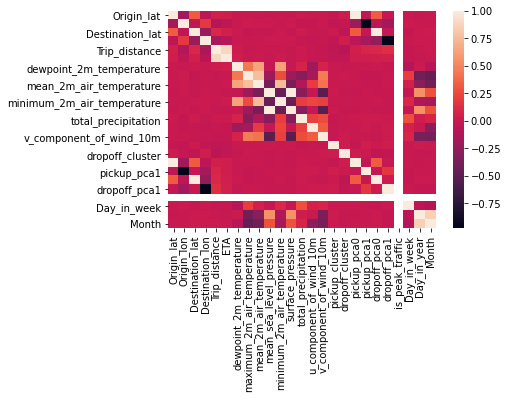

In [60]:
import seaborn as sb
sb.heatmap(train.corr())

In [61]:
train.corr()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,pickup_cluster,dropoff_cluster,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,is_peak_traffic,Day_in_week,Day_in_year,Month
Origin_lat,1.000000,-0.172044,0.318267,-0.058526,0.046949,0.036195,0.003955,-0.001166,-0.000847,-0.010405,0.002749,-0.010432,0.006493,-0.002586,0.000823,-0.017851,0.022361,0.999734,-0.044762,0.317969,-0.011378,NaN,-0.002667,-0.005218,-0.000509
Origin_lon,-0.172044,1.000000,-0.048555,0.175337,-0.093406,-0.045261,0.002435,0.012660,0.005492,0.004539,0.001727,0.004693,-0.013279,-0.014057,-0.003184,-0.032922,-0.016213,-0.194718,-0.976401,-0.052356,-0.168593,NaN,0.007148,-0.000865,0.003411
Destination_lat,0.318267,-0.048555,1.000000,-0.213403,0.090514,0.047292,0.008906,-0.013950,-0.005920,-0.005523,0.004869,-0.005660,0.013397,-0.003748,-0.005586,0.009509,-0.042865,0.318038,-0.020534,0.999745,-0.005543,NaN,-0.015685,0.004489,0.011881
Destination_lon,-0.058526,0.175337,-0.213403,1.000000,-0.148187,-0.065912,0.001998,0.003817,0.002713,0.005094,0.005153,0.005156,-0.007567,-0.011986,-0.011228,-0.028201,0.037109,-0.062380,-0.164982,-0.235406,-0.975766,NaN,0.003541,0.010815,0.011302
Trip_distance,0.046949,-0.093406,0.090514,-0.148187,1.000000,0.898083,0.016564,-0.004880,0.000022,-0.003596,0.002992,-0.003649,0.004091,-0.009084,-0.012385,-0.045615,-0.070985,0.048934,0.084432,0.093469,0.131406,NaN,-0.016860,0.002098,0.006597
ETA,0.036195,-0.045261,0.047292,-0.065912,0.898083,1.000000,0.032448,-0.002314,0.008349,-0.006505,0.016529,-0.006516,0.008046,-0.013946,-0.014016,-0.036053,-0.041304,0.037099,0.037964,0.048570,0.056872,NaN,-0.017832,-0.003891,0.004008
dewpoint_2m_temperature,0.003955,0.002435,0.008906,0.001998,0.016564,0.032448,1.000000,0.442193,0.643187,-0.014800,0.626726,-0.010738,0.072687,-0.191976,0.071109,0.001137,-0.007451,0.003881,-0.003337,0.008814,-0.004040,NaN,-0.094194,0.004873,-0.082699
maximum_2m_air_temperature,-0.001166,0.012660,-0.013950,0.003817,-0.004880,-0.002314,0.442193,1.000000,0.761819,-0.196757,0.263273,-0.188932,-0.297754,-0.164461,0.455795,0.003359,0.005883,-0.001458,-0.012583,-0.013966,-0.000782,NaN,0.197117,-0.401348,-0.461407
mean_2m_air_temperature,-0.000847,0.005492,-0.005920,0.002713,0.000022,0.008349,0.643187,0.761819,1.000000,-0.372514,0.753583,-0.367071,-0.105894,0.192678,0.415631,-0.000528,0.001904,-0.000972,-0.005384,-0.005952,-0.001451,NaN,0.056223,-0.296536,-0.409938
mean_sea_level_pressure,-0.010405,0.004539,-0.005523,0.005094,-0.003596,-0.006505,-0.014800,-0.196757,-0.372514,1.000000,-0.439080,0.999963,-0.300135,-0.015161,-0.524581,0.011698,-0.006916,-0.010466,-0.002322,-0.005612,-0.003977,NaN,-0.024905,0.552110,0.288680
